# Abstract classification with Neural Nets

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

import utils # all datareading and preprocessing functionality

## Current analysis configuration

In [2]:
file1 = './data/abstract_set1.txt'
file2 = './data/abstract_set2.txt'
data_selection = 'abstract_clean'
label_selection = 'label'

In [3]:
# the custom class Tokenizer can also lemmatize, and remove short words, digits and stopwords
stopwords = utils.get_stopwords(custom = {'wa', 'use', 'using', 'one', 'two', 'three', 'study'}) 
#custom = {'pesticide', 'pesticides'})

tokenizer = utils.Tokenizer(stop_words=stopwords, min_length=3)
#tokenizer = utils.StemTokenizer()

vectorizer = TfidfVectorizer(tokenizer=tokenizer, max_features=2500)
#vectorizer = CountVectorizer(tokenizer=tokenizer) 

**Note on max_features:** If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus. Otherwise, all features are used.

## Load, preprocess and inspect

In [4]:
data = utils.read_abstract_data(file1, file2)

# no need to catch return value; dataframe operations are in-place
# no need to remove punctuation in this step when using nltk.tokenize_word() 
# which is implemented in utils.tokenize_text()
utils.preprocess_text(data)

data.head()

,pmid,title,abstract,label,text_label,title_clean,abstract_clean
0,29990300,Oxidative stress in triazine pesticide toxicit...,This review article provides a summary of the ...,0,set1,oxidative stress in triazine pesticide toxicit...,this review article provides a summary of the ...
1,29990732,Toxicity induced by glyphosate and glyphosate-...,Glyphosate is the active component of many com...,0,set1,toxicity induced by glyphosate and glyphosate-...,glyphosate is the active component of many com...
2,29999060,Direct kinetics study of CH2OO + methyl vinyl ...,Methyl vinyl ketone (MVK) and methacrolein (MA...,0,set1,direct kinetics study of ch2oo + methyl vinyl ...,methyl vinyl ketone (mvk) and methacrolein (ma...
3,30003825,Dihydromyricetin improves vascular hyporespons...,CONTEXT: Dihydromyricetin (DMY) has oxidation ...,0,set1,dihydromyricetin improves vascular hyporespons...,context: dihydromyricetin (dmy) has oxidation ...
4,30015122,Glyphosate and atrazine in rainfall and soils ...,The presence in the atmosphere of glyphosate (...,0,set1,glyphosate and atrazine in rainfall and soils ...,the presence in the atmosphere of glyphosate (...


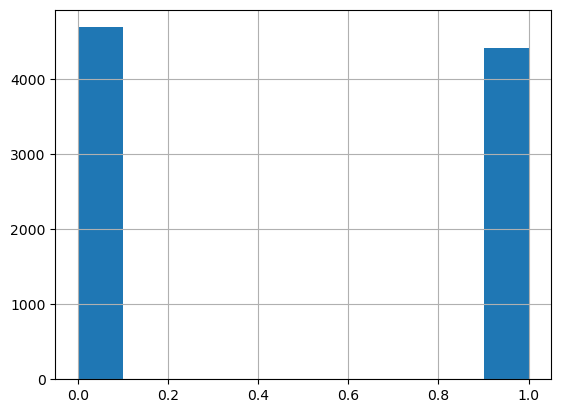

In [5]:
data[label_selection].hist();

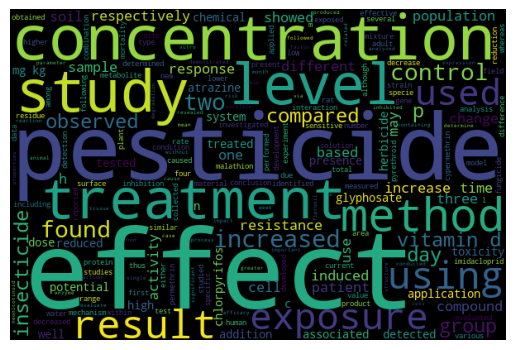

In [9]:
utils.visualize(data, 'set1')

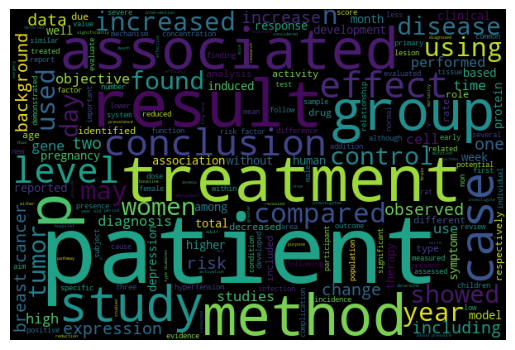

In [10]:
utils.visualize(data, 'set2')

## Create train and test data


In [6]:
x_train, x_test, y_train, y_test = train_test_split(data[data_selection], data[label_selection], random_state=123)

In [7]:
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)
# Note the use of different functions for train and test data !

x_train_vec.shape # is a sparse matrix!

/Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(6832, 2500)

In [8]:
# data must not be sparse matrix before passing into tensorflow
x_train_vec = x_train_vec.toarray()
x_test_vec = x_test_vec.toarray()
x_train_vec.shape

(6832, 2500)

In [9]:
#run this to relad the utils module after changes during session
# from importlib import reload 
# reload(utils)
#utils.plot_top_words(lda, feature_names, n_components = n_components, n_top_words=10);

<module 'utils' from '/Users/michielnoback/Library/CloudStorage/OneDrive-HanzehogeschoolGroningen/study_materials/nlp_course_notebooks/pesticide_literature/utils.py'>

In [10]:
# number of columns from input dimensions required to specify in the model
print(x_train_vec.shape)
D = x_train_vec.shape[1]

(6832, 2500)


In [11]:
# build model
i = Input(shape=(D,))

# Dense layer with D inputs and one output; no sigmoid here because included in loss
x = Dense(1)(i) 

model = Model(i, x)

In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,501 (9.77 KB)

 Trainable params: 2,501 (9.77 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
  loss=BinaryCrossentropy(from_logits=True), # different from regression
  optimizer=Adam(learning_rate=0.01), # much lower learning rate
  metrics=['accuracy']            # different from regression; will have two metrics: accuracy and loss
)

In [14]:
r = model.fit(
  x_train_vec, y_train,
  #validation data only with classification!
  validation_data=(x_test_vec, y_test),
  epochs=40,
  batch_size=128,
)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5641 - loss: 0.6113 - val_accuracy: 0.8314 - val_loss: 0.4365
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8593 - loss: 0.3954 - val_accuracy: 0.8788 - val_loss: 0.3367
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8930 - loss: 0.3114 - val_accuracy: 0.8955 - val_loss: 0.2886
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9076 - loss: 0.2671 - val_accuracy: 0.9039 - val_loss: 0.2601
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9137 - loss: 0.2355 - val_accuracy: 0.9122 - val_loss: 0.2415
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9310 - loss: 0.2079 - val_accuracy: 0.9135 - val_loss: 0.2274
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9380 - loss: 0.1902 - val_accuracy: 0.9179 - val_loss: 0.2172
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9395 - loss: 0.1832 - val_accuracy: 0.9223 - val_loss:

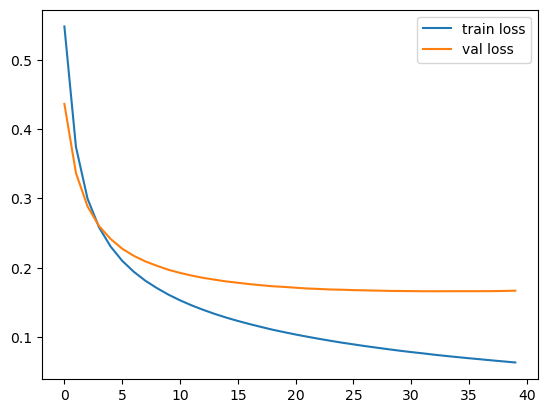

In [15]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

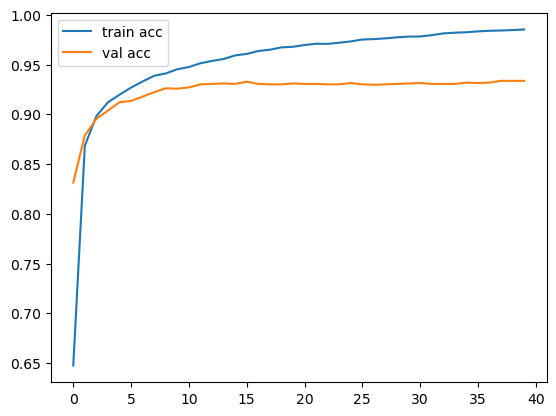

In [16]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [17]:
# The outputs are not probabilities but logits;
# therefore, this check for bigger than zero (=positive class)
# mutltiply by one to get numbers instead of booleans
P_train = ((model.predict(x_train_vec) > 0) * 1.0).flatten()
P_test = ((model.predict(x_test_vec) > 0) * 1.0).flatten()

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


In [18]:
cm_train = confusion_matrix(y_train, P_train, normalize='true')
cm_train

array([[0.98977563, 0.01022437],
       [0.01057082, 0.98942918]])

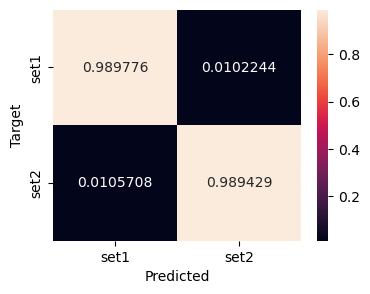

In [19]:
utils.plot_confusion_matrix(cm_train, ['set1', 'set2'])

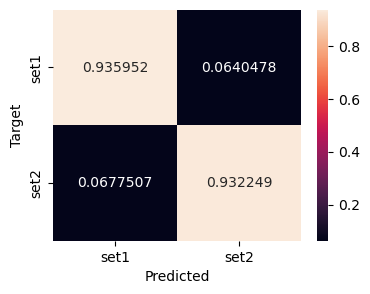

In [20]:
cm_test = confusion_matrix(y_test, P_test, normalize='true')
utils.plot_confusion_matrix(cm_test, ['set1', 'set2'])

In [21]:
Pr_train = model.predict(x_train_vec)
Pr_test = model.predict(x_test_vec)
print("Train AUC:", roc_auc_score(y_train, Pr_train))
print("Test AUC:", roc_auc_score(y_test, Pr_test))

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
Train AUC: 0.9992058693273331
Test AUC: 0.9826212665770266


In [22]:
print("Train F1:", f1_score(y_train, P_train))
print("Test F1:", f1_score(y_test, P_test))

Train F1: 0.989279782575872
Test F1: 0.9322493224932249


In [23]:
model.layers

[<InputLayer name=input_layer, built=True>, <Dense name=dense, built=True>]

In [24]:
model.layers[1].get_weights()
# word weights and bias

[array([[ 0.41826633],
        [-0.4328185 ],
        [-4.5463433 ],
        ...,
        [-2.5377553 ],
        [-2.8543725 ],
        [ 0.2548529 ]], dtype=float32),
 array([-0.21963081], dtype=float32)]

In [25]:
# store the weights
weights = model.layers[1].get_weights()[0]

In [26]:
word_index_map = vectorizer.vocabulary_
#word_index_map

Gives:
```
{'treated': 1895,
 'available': 183,
 'commercial': 339,
 'form': 744,
 'resulting': 1597,
 'tissue': 1864,
 'change': 285,
 'compared': 345,
 'control': 399,
 'group': 807,
 'examination': 661,
 'utilized': 1932,
 'insect': 950,
 'fat': 710,
 ...
```

In [28]:
# let's look at the weights for each word
# try it with different threshold values!
threshold = 4

print("terms in favor of set 1:\n")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = weights[index, 0]
    if weight > threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: -x[1])
for i in range(20):
  word, weight = word_weight_tuples[i]
  print(word, weight)

terms in favor of set 1:

depression 7.7571754
neurodegenerative 7.1695714
asthma 6.7961907
switching 6.6330824
neurotoxicity 6.443469
hypertension 6.2660284
anemia 6.0377893
imbalance 5.9502664
parkinson 5.9384947
adenocarcinoma 5.842203
lymphoma 5.742021
osteosarcoma 5.5646024
infarction 5.491016
fertility 5.4217863
pregnancy 5.399271
hepatitis 5.291673
cyst 5.2899413
cirrhosis 5.2812314
neuroprotective 5.156865
fatigue 5.137759


In [29]:
print("Terms in favor of set 2:\n")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = weights[index, 0]
    if weight < -threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: x[1])
for i in range(20):
  word, weight = word_weight_tuples[i]
  print(word, weight)


Terms in favor of set 2:

cholecalciferol -9.697223
acrolein -8.467733
azobenzene -8.209453
chloride -8.104606
benzalkonium -7.9637613
polyacrylonitrile -7.182524
permethrin -6.8227262
acrylonitrile -6.7203774
vitamin -6.532001
chlorpyrifos -6.253762
tetraethylammonium -6.2462487
chemical -6.0596046
calcitriol -6.009758
supplementation -5.9571676
pyrethroid -5.950249
cypermethrin -5.946079
herbicide -5.8829136
pesticide -5.843263
organochlorine -5.8214283
glyphosate -5.783119


### TODO: how can this information be turned into use cases?